In [1]:
import pandas as pd
import json
import os
from IPython.display import HTML
import matplotlib.pyplot as plt
import numpy as np; print(f"\t\t– NUMPY VERSION: {np.__version__}");
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm

		– NUMPY VERSION: 1.26.0


In [2]:
DATA_DIR = "./Dataset_GISLR/asl-signs"

Snippets taken from:
- https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#imports
- https://www.kaggle.com/code/robikscube/sign-language-recognition-eda-twitch-stream

## Helper functions

In [3]:
def get_hand_points(hand):
    """Return x, y lists of normalized spatial coordinates for each finger in the hand dataframe."""
    def __get_hand_ax(_axis):
        return [np.nan_to_num(_x) for _x in 
            [hand.iloc[i][_axis] for i in range(5)]+\
            [[hand.iloc[i][_axis] for i in range(j, j+4)] for j in range(5, 21, 4)]+\
            [hand.iloc[i][_axis] for i in special_pts]]
    special_pts = [0, 5, 9, 13, 17, 0]
    return [__get_hand_ax(_ax) for _ax in ['x','y','z']]

def get_pose_points(pose):
    """
    Extracts x and y coordinates from the provided dataframe for pose landmarks.

    Args:
        pose (pandas.DataFrame): Dataframe containing pose landmarks with columns ['x', 'y', 'z', 'visibility', 'presence'].

    Returns:
        tuple: Two lists of x and y coordinates, respectively.

    """
    def __get_pose_ax(_axis):
        return [np.nan_to_num(_x) for _x in [
            [pose.iloc[i][_axis] for i in [8, 6, 5, 4, 0, 1, 2, 3, 7]], 
            [pose.iloc[i][_axis] for i in [10, 9]], 
            [pose.iloc[i][_axis] for i in [22, 16, 20, 18, 16, 14, 12, 11, 13, 15, 17, 19, 15, 21]], 
            [pose.iloc[i][_axis] for i in [12, 24, 26, 28, 30, 32, 28]], 
            [pose.iloc[i][_axis] for i in [11, 23, 25, 27, 29, 31, 27]], 
            [pose.iloc[i][_axis] for i in [24, 23]]
        ]]
    return [__get_pose_ax(_ax) for _ax in ['x','y','z']]


def animation_frame(f, event_df, ax, ax_pad=0.2, style="full", 
                    face_color="spring", pose_color="autumn", lh_color="winter", rh_color="summer"):
    """
    Function called by FuncAnimation to animate the plot with the provided frame.

    Args:
        f (int): The current frame number.

    Returns:
        None.
    """
    
    face_color = plt.cm.get_cmap(face_color)
    pose_color = plt.cm.get_cmap(pose_color)
    rh_color = plt.cm.get_cmap(rh_color)
    lh_color = plt.cm.get_cmap(lh_color)
    
    sign_df = event_df.copy()
    
    # Clear axis and fix the axis
    ax.clear()
    if style=="full":
        xmin = sign_df['x'].min() - ax_pad
        xmax = sign_df['x'].max() + ax_pad
        ymin = sign_df['y'].min() - ax_pad
        ymax = sign_df['y'].max() + ax_pad
    elif style=="hands":
        xmin = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['x'].min() - ax_pad
        xmax = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['x'].max() + ax_pad
        ymin = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['y'].min() - ax_pad
        ymax = sign_df[sign_df.type.isin(["left_hand", "right_hand"])]['y'].max() + ax_pad
    else:
        xmin = sign_df[sign_df.type==style]['x'].min() - ax_pad
        xmax = sign_df[sign_df.type==style]['x'].max() + ax_pad
        ymin = sign_df[sign_df.type==style]['y'].min() - ax_pad
        ymax = sign_df[sign_df.type==style]['y'].max() + ax_pad
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.axis(False) # Remove the axis lines
    
    # Normalize depth
    zmin, zmax = sign_df['z'].min(), sign_df['z'].max()
    sign_df['z'] = (sign_df['z']-zmin)/(zmax-zmin)
    
    # Get data for current frame
    frame = sign_df[sign_df.frame==f]
    
    # Left Hand
    if style.lower() in ["left_hand", "hands", "full"]:
        left = frame[frame.type=='left_hand']
        lx, ly, lz = get_hand_points(left)
        for i in range(len(lx)):
            if type(lx[i])!=np.float64:
                lh_clr = [lh_color(((np.abs(_x)+np.abs(_y))/2)) for _x, _y in zip(lx[i], ly[i])]
                lh_clr = tuple(sum(_x)/len(_x) for _x in zip(*lh_clr))
            else: 
                lh_clr = lh_color(((np.abs(lx[i])+np.abs(ly[i]))/2))
            ax.plot(lx[i], ly[i], color=lh_clr, alpha=lz[i].mean())
    
    # Right Hand
    if style.lower() in ["right_hand", "hands", "full"]:
        right = frame[frame.type=='right_hand']
        rx, ry, rz = get_hand_points(right)
        for i in range(len(rx)):
            if type(rx[i])!=np.float64:
                rh_clr = [rh_color((np.abs(_x)+np.abs(_y))/2) for _x, _y in zip(rx[i], ry[i])] 
                rh_clr = tuple(sum(_x)/len(_x) for _x in zip(*rh_clr))
            else:
                rh_clr = rh_color(((np.abs(rx[i])+np.abs(ry[i]))/2))
            ax.plot(rx[i], ry[i], color=rh_clr, alpha=rz[i].mean())
    
    # Pose
    if style.lower() in ["pose", "full"]:
        pose = frame[frame.type=='pose']
        px, py, pz = get_pose_points(pose)
        for i in range(len(px)):
            if type(px[i])!=np.float64:
                pose_clr = [pose_color(((np.abs(_x)+np.abs(_y))/2)) for _x, _y in zip(px[i], py[i])]
                pose_clr = tuple(sum(_x)/len(_x) for _x in zip(*pose_clr))
            else: 
                pose_clr = pose_color(((np.abs(px[i])+np.abs(py[i]))/2))
            ax.plot(px[i], py[i], color=pose_clr, alpha=pz[i].mean())
        
    if style.lower() in ["face", "full"]:
        face = frame[frame.type=='face'][['x', 'y', 'z']].values
        fx, fy, fz = face[:,0], face[:,1], face[:,2]
        for i in range(len(fx)):
            ax.plot(fx[i], fy[i], '.', color=pose_color(fz[i]), alpha=fz[i])
    
    # Use this so we don't get an extra return
    plt.close()
    
    
def plot_event(event_df, style="full"):
    # Create figure and animation
    fig, ax = plt.subplots()
    l, = ax.plot([], [])
    animation = FuncAnimation(fig, func=lambda x: animation_frame(x, event_df, ax, style=style), 
                              frames=event_df["frame"].unique())
    
    # Display animation as HTML5 video
    return HTML(animation.to_html5_video())


In [4]:
def flatten_l_o_l(nested_list):
    """Flatten a list of lists into a single list.

    Args:
        nested_list (list): 
            – A list of lists (or iterables) to be flattened.

    Returns:
        list: A flattened list containing all items from the input list of lists.
    """
    return [item for sublist in nested_list for item in sublist]


def print_ln(symbol="-", line_len=110, newline_before=False, newline_after=False):
    """Print a horizontal line of a specified length and symbol.

    Args:
        symbol (str, optional): 
            – The symbol to use for the horizontal line
        line_len (int, optional): 
            – The length of the horizontal line in characters
        newline_before (bool, optional): 
            – Whether to print a newline character before the line
        newline_after (bool, optional): 
            – Whether to print a newline character after the line
    """
    if newline_before: print();
    print(symbol * line_len)
    if newline_after: print();
        
        
def read_json_file(file_path):
    """Read a JSON file and parse it into a Python object.

    Args:
        file_path (str): The path to the JSON file to read.

    Returns:
        dict: A dictionary object representing the JSON data.
        
    Raises:
        FileNotFoundError: If the specified file path does not exist.
        ValueError: If the specified file path does not contain valid JSON data.
    """
    try:
        # Open the file and load the JSON data into a Python object
        with open(file_path, 'r') as file:
            json_data = json.load(file)
        return json_data
    except FileNotFoundError:
        # Raise an error if the file path does not exist
        raise FileNotFoundError(f"File not found: {file_path}")
    except ValueError:
        # Raise an error if the file does not contain valid JSON data
        raise ValueError(f"Invalid JSON data in file: {file_path}")
        
def get_sign_df(pq_path, invert_y=True):
    sign_df = pd.read_parquet(pq_path)
    
    # y value is inverted (Thanks @danielpeshkov)
    if invert_y: sign_df["y"] *= -1 
        
    return sign_df


ROWS_PER_FRAME = 543  # number of landmarks per frame
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)


In [5]:
s2p_map = {k.lower():v for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
p2s_map = {v:k for k,v in read_json_file(os.path.join(DATA_DIR, "sign_to_prediction_index_map.json")).items()}
encoder = lambda x: s2p_map.get(x.lower())
decoder = lambda x: p2s_map.get(x)
print(s2p_map)

FileNotFoundError: File not found: ./Dataset_GISLR/asl-signs\sign_to_prediction_index_map.json

## Train.csv

In [ ]:
train_df = pd.read_csv(os.path.join(DATA_DIR, "train.csv")) 
train_df["path"] = DATA_DIR+"/"+train_df["path"]
display(train_df)

,path,participant_id,sequence_id,sign
0,./Dataset_GISLR/asl-signs/train_landmark_files...,26734,1000035562,blow
1,./Dataset_GISLR/asl-signs/train_landmark_files...,28656,1000106739,wait
2,./Dataset_GISLR/asl-signs/train_landmark_files...,16069,100015657,cloud
3,./Dataset_GISLR/asl-signs/train_landmark_files...,25571,1000210073,bird
4,./Dataset_GISLR/asl-signs/train_landmark_files...,62590,1000240708,owie
...,...,...,...,...
94472,./Dataset_GISLR/asl-signs/train_landmark_files...,53618,999786174,white
94473,./Dataset_GISLR/asl-signs/train_landmark_files...,26734,999799849,have
94474,./Dataset_GISLR/asl-signs/train_landmark_files...,25571,999833418,flower
94475,./Dataset_GISLR/asl-signs/train_landmark_files...,29302,999895257,room


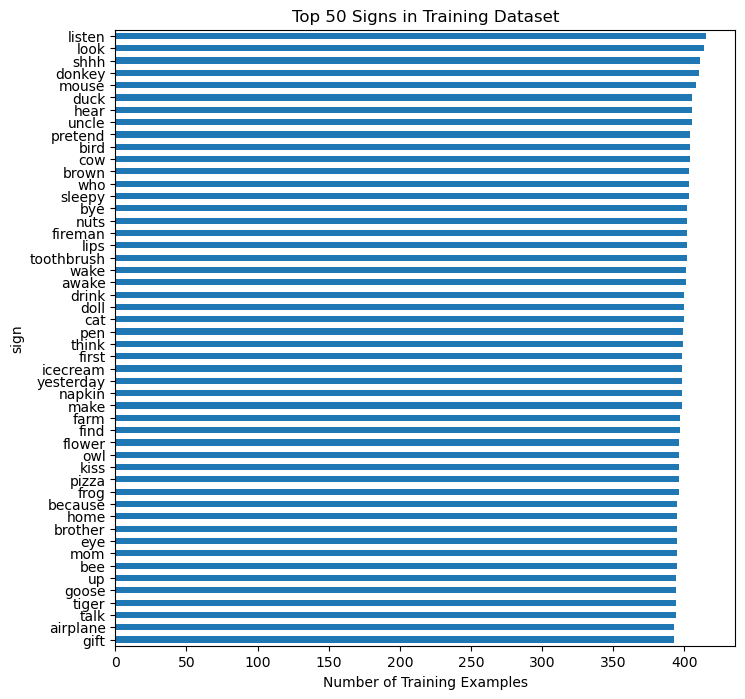

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
train_df["sign"].value_counts().head(50).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Top 50 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

In [ ]:
# Comparing multiple parquet files
listen_files = train_df.query('sign == "listen"')["path"].values
for i, f in enumerate(listen_files):
    example_landmark = pd.read_parquet(f"{f}")
    unique_frames = example_landmark["frame"].nunique()
    unique_types = example_landmark["type"].nunique()
    types_in_video = example_landmark["type"].unique()
    print(
        f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
    )
    if i == 20:
        break

The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 23 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 28 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 68 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 16 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 8 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 33 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The file has 13 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']
The 

In [ ]:
display(train_df["participant_id"].astype(str).describe().to_frame().T)

,count,unique,top,freq
participant_id,94477,21,49445,4968


In [ ]:
display(train_df["sign"].describe().to_frame().T)

,count,unique,top,freq
sign,94477,250,listen,415


## Look at parquet files

In [ ]:
N_PARQUETS_TO_READ = 100  # So we don't have to load all 95k
files_read = 0
combined_meta = {}
for i, d in  train_df.iterrows():
    file_path = d["path"]
    example_landmark = pd.read_parquet(file_path)
    # Get the number of landmarks with x,y,z data per type
    meta = (
        example_landmark.dropna(subset=["x", "y", "z"])["type"].value_counts().to_dict()
    )
    meta["frames"] = example_landmark["frame"].nunique()
    xyz_meta = (
        example_landmark.agg(
            {
                "x": ["min", "max", "mean"],
                "y": ["min", "max", "mean"],
                "z": ["min", "max", "mean"],
            }
        )
        .unstack()
        .to_dict()
    )

    for key in xyz_meta.keys():
        new_key = key[0] + "_" + key[1]
        meta[new_key] = xyz_meta[key]
    combined_meta[file_path] = meta
    files_read = files_read + 1
    if files_read >= N_PARQUETS_TO_READ:
        break

print(combined_meta)
train_with_meta = train_df.merge(
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={"index": "path"}),
    how="left",
)
train_with_meta.head()


{'./Dataset_GISLR/asl-signs/train_landmark_files/26734/1000035562.parquet': {'face': 10764, 'pose': 759, 'right_hand': 231, 'frames': 23, 'x_min': -0.03181135654449463, 'x_max': 1.2943496704101562, 'x_mean': 0.5367392186897586, 'y_min': 0.22415050864219666, 'y_max': 2.1478259563446045, 'y_mean': 0.3837467147272238, 'z_min': -2.7826244831085205, 'z_max': 1.9108154773712158, 'z_mean': -0.03569246538091114}, './Dataset_GISLR/asl-signs/train_landmark_files/28656/1000106739.parquet': {'face': 5148, 'pose': 363, 'right_hand': 42, 'frames': 11, 'x_min': -0.017061874270439148, 'x_max': 1.0159311294555664, 'x_mean': 0.5547942654910625, 'y_min': 0.32927292585372925, 'y_max': 2.2227323055267334, 'y_mean': 0.5049115718162406, 'z_min': -2.5439696311950684, 'z_max': 1.6276206970214844, 'z_mean': -0.04066203157380095}, './Dataset_GISLR/asl-signs/train_landmark_files/16069/100015657.parquet': {'face': 49140, 'pose': 3465, 'left_hand': 588, 'frames': 105, 'x_min': -0.04292302206158638, 'x_max': 1.19783

,path,participant_id,sequence_id,sign,face,pose,right_hand,frames,x_min,x_max,x_mean,y_min,y_max,y_mean,z_min,z_max,z_mean,left_hand
0,./Dataset_GISLR/asl-signs/train_landmark_files...,26734,1000035562,blow,10764.0,759.0,231.0,23.0,-0.031811,1.294350,0.536739,0.224151,2.147826,0.383747,-2.782624,1.910815,-0.035692,NaN
1,./Dataset_GISLR/asl-signs/train_landmark_files...,28656,1000106739,wait,5148.0,363.0,42.0,11.0,-0.017062,1.015931,0.554794,0.329273,2.222732,0.504912,-2.543970,1.627621,-0.040662,NaN
2,./Dataset_GISLR/asl-signs/train_landmark_files...,16069,100015657,cloud,49140.0,3465.0,NaN,105.0,-0.042923,1.197836,0.438283,0.248094,2.591290,0.457483,-2.838325,1.587503,-0.047699,588.0
3,./Dataset_GISLR/asl-signs/train_landmark_files...,25571,1000210073,bird,5616.0,396.0,252.0,12.0,-0.129268,1.156573,0.478509,0.310272,2.294936,0.503025,-3.018237,2.196296,-0.044505,NaN
4,./Dataset_GISLR/asl-signs/train_landmark_files...,62590,1000240708,owie,8424.0,594.0,378.0,18.0,0.072425,1.165405,0.488842,0.405282,2.264609,0.545811,-2.970331,1.360011,-0.054411,NaN


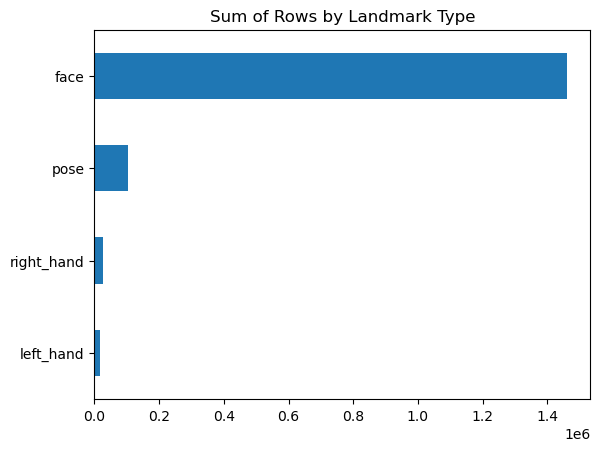

In [ ]:
train_with_meta[["face", "pose", "left_hand", "right_hand"]].sum().sort_values().plot(
    kind="barh", title="Sum of Rows by Landmark Type"
)
plt.show()

## Look at a single parquet

In [ ]:
DEMO_ROW = 283
print(f"\n\n... DEMO SIGN/EVENT DATAFRAME FOR ROW {DEMO_ROW} - SIGN={train_df.iloc[DEMO_ROW]['sign']} ...\n")
demo_sign_df = get_sign_df(train_df.iloc[DEMO_ROW]["path"])
print(demo_sign_df.shape)
display(demo_sign_df)

unique_frames = demo_sign_df["frame"].nunique()
unique_types = demo_sign_df["type"].nunique()
types_in_video = demo_sign_df["type"].unique()
print(
    f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
)

plot_event(demo_sign_df)



... DEMO SIGN/EVENT DATAFRAME FOR ROW 283 - SIGN=face ...

(9231, 7)


,frame,row_id,type,landmark_index,x,y,z
0,23,23-face-0,face,0,0.381393,-0.377334,-0.045009
1,23,23-face-1,face,1,0.387510,-0.333088,-0.060799
2,23,23-face-2,face,2,0.384334,-0.349668,-0.037500
3,23,23-face-3,face,3,0.377555,-0.302792,-0.038101
4,23,23-face-4,face,4,0.388338,-0.322209,-0.062246
...,...,...,...,...,...,...,...
9226,39,39-right_hand-16,right_hand,16,NaN,NaN,NaN
9227,39,39-right_hand-17,right_hand,17,NaN,NaN,NaN
9228,39,39-right_hand-18,right_hand,18,NaN,NaN,NaN
9229,39,39-right_hand-19,right_hand,19,NaN,NaN,NaN


The file has 17 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']


C:\Users\User\AppData\Local\Temp\ipykernel_8836\3395289502.py:46: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  face_color = plt.cm.get_cmap(face_color)
C:\Users\User\AppData\Local\Temp\ipykernel_8836\3395289502.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pose_color = plt.cm.get_cmap(pose_color)
C:\Users\User\AppData\Local\Temp\ipykernel_8836\3395289502.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  rh_color = plt.cm.get_cmap(rh_color)
C:\Users\User\AppData\Loca

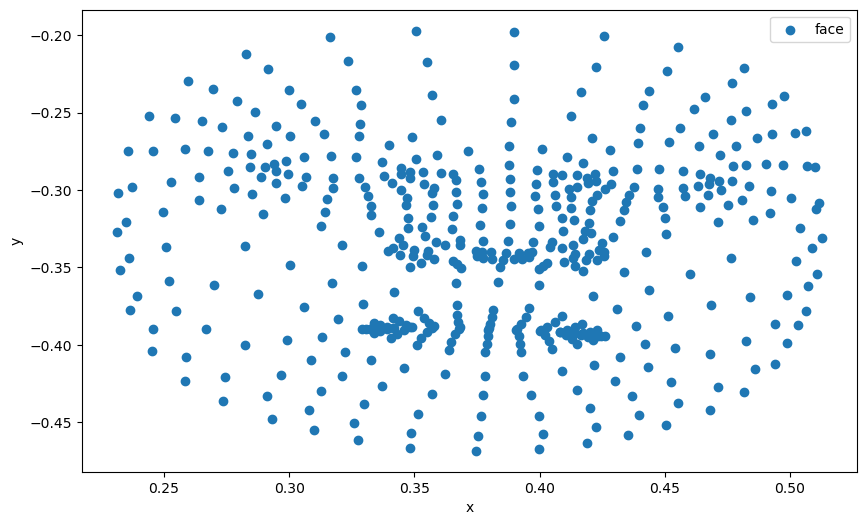

In [ ]:
example_frame = demo_sign_df.query("frame == 23 and type== 'face'")
plt.figure(figsize=(10, 6))
types = example_frame['type'].unique()

for t in types:
    data = example_frame[example_frame['type'] == t]
    plt.scatter(data['x'], data['y'], label=t)

plt.xlabel('x')
plt.ylabel('y')
plt.legend() 
plt.show()